In [1329]:

from pathlib import Path
from typing import Sequence
from unittest.mock import patch

import cv2
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jnp.set_printoptions(precision=5, suppress=True, linewidth=120)


In [1330]:
def load_frame_from_path(frame_path: Path):
    img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise Exception(f'frame not found at {frame_path}')
    as_array = jnp.asarray(img)
    assert as_array.ndim == 2
    normalized = as_array / 255.0
    return normalized


def chw_img(img: jax.Array) -> jax.Array:
    assert img.ndim == 2
    return img[None, :, :]


def get_offsets(input_size: int, output_size: int):
    reminder = input_size - output_size
    start = reminder // 2
    end = input_size - (reminder - start)
    return start, end


def crop(img: jax.Array, size: int) -> jax.Array:
    H, W = img.shape
    start_y, end_y = get_offsets(H, size)
    start_x, end_x = get_offsets(W, size)
    return img[start_y:end_y, start_x:end_x]


def load_frame(path: Path, size: int) -> jax.Array:
    img = load_frame_from_path(path)
    cropped = crop(img, size)
    return chw_img(cropped)




In [1331]:
def reduce_images_separable_convolution(imgs: jax.Array, kernel: jax.Array,
                                        stride: int = 2) -> jax.Array:
    N, C, H, W = imgs.shape
    kernel_size = kernel.shape[-1]
    OH = (H - kernel_size) // stride + 1
    OW = (W - kernel_size) // stride + 1
    img_for_h_conv = imgs.reshape(N * C * H, 1, W)
    img_h_conv = jax.lax.conv_general_dilated(
        img_for_h_conv,
        kernel,
        window_strides=(stride,),
        padding=((0, 0),),
        dimension_numbers=('NCW', 'IOW', 'NCW'),
    ).reshape(N, C, H, OW)
    img_for_v_conv = img_h_conv.transpose(0, 1, 3, 2).reshape(N * C * OW, 1, H)
    img_v_conv = jax.lax.conv_general_dilated(
        img_for_v_conv,
        kernel,
        window_strides=(stride,),
        padding=((0, 0),),
        dimension_numbers=('NCH', 'IOH', 'NCH'),
    ).reshape(N, C, OW, OH)
    return img_v_conv.transpose(0, 1, 3, 2)


def reduce_frames(imgs: jax.Array) -> jax.Array:
    a = 1.0
    b = 0.4
    kernel = jnp.array([b, a, a, b]).reshape(1, 1, 4)
    kernel = kernel / jnp.sum(kernel)
    return reduce_images_separable_convolution(imgs, kernel, 2)


b1 = jnp.stack(
    [jnp.arange(64).reshape(8, 8).astype(jnp.float32),
     jnp.arange(64, 128).reshape(8, 8).astype(jnp.float32)],
    axis=0
)


def build_image_pyramid(img: jax.Array, levels: int) -> Sequence[jax.Array]:
    C, H, W = img.shape
    current = img[None, :, :, :]
    pyramid = [current]
    for level in range(levels):
        current = reduce_frames(current)
        pyramid.append(current)
    return pyramid

# a = 1.0
# b = 0.4
# kernel = jnp.array([b,a,a,b])
# k2 = jnp.outer(kernel,kernel)
# k2 / jnp.sum(k2)

In [1332]:
f1 = load_frame(Path('./datasets/frames/desk/frame_000240.png'), 158)
f2 = load_frame(Path('./datasets/frames/desk/frame_000245.png'), 158)
f1_pyramid = build_image_pyramid(f1, 4)
f2_pyramid = build_image_pyramid(f2, 4)
[img.shape for img in f1_pyramid]


[(1, 1, 158, 158),
 (1, 1, 78, 78),
 (1, 1, 38, 38),
 (1, 1, 18, 18),
 (1, 1, 8, 8)]

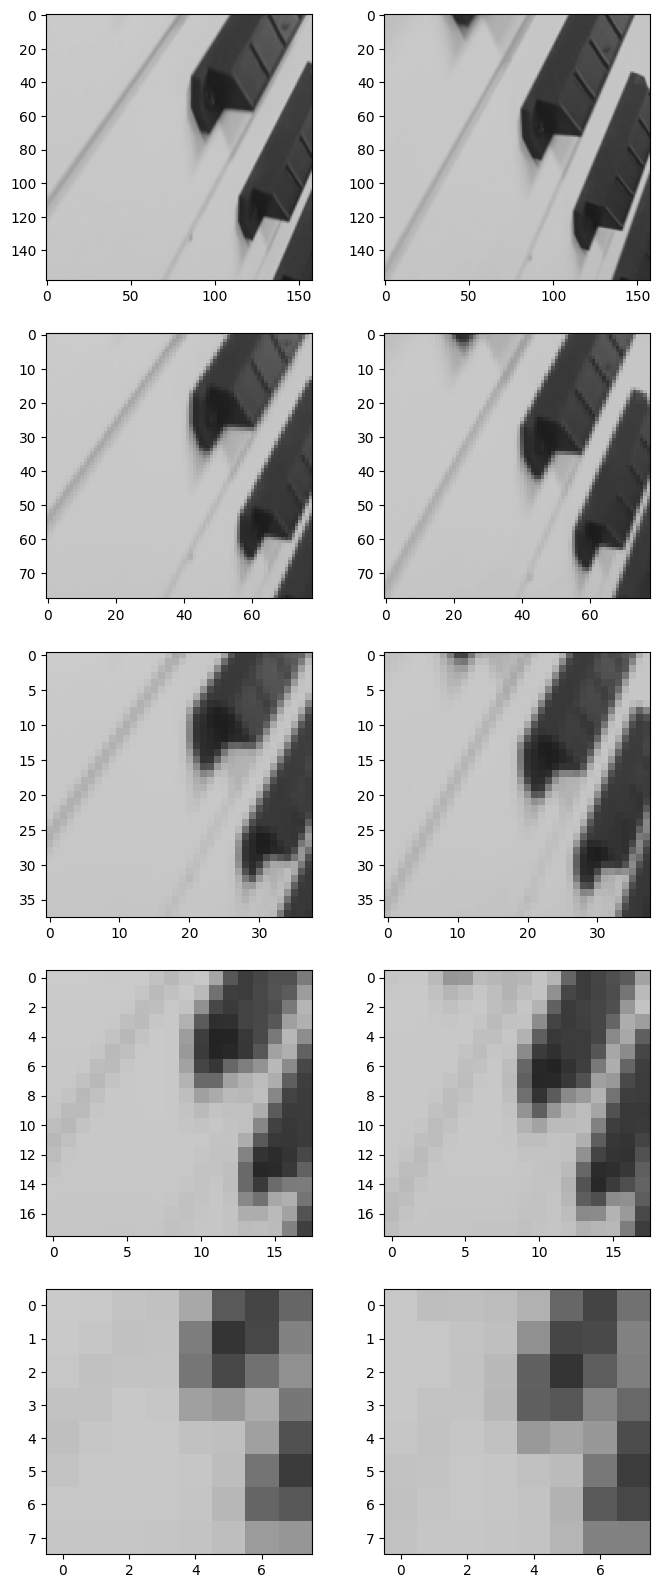

In [1333]:
def display_pyramid_nchw(pyramid):
    fig, axes = plt.subplots(len(pyramid), 1, figsize=(4, 4 * len(pyramid)))
    for img, axe in zip(pyramid, axes):
        axe.imshow(img.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
    plt.show()


def display_pyramids_side_by_side_nchw(pyramid1, pyramid2):
    assert len(pyramid1) == len(pyramid2)
    length = len(pyramid1)
    fig, axes = plt.subplots(length, 2, figsize=(8, 4 * length))
    for img1, img2, (ax1, ax2) in zip(pyramid1, pyramid2, axes):
        ax1.imshow(img1.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
        ax2.imshow(img2.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
    plt.show()


display_pyramids_side_by_side_nchw(f1_pyramid, f2_pyramid)
# print([p.shape for p in f1_pyramid])

0.40738165


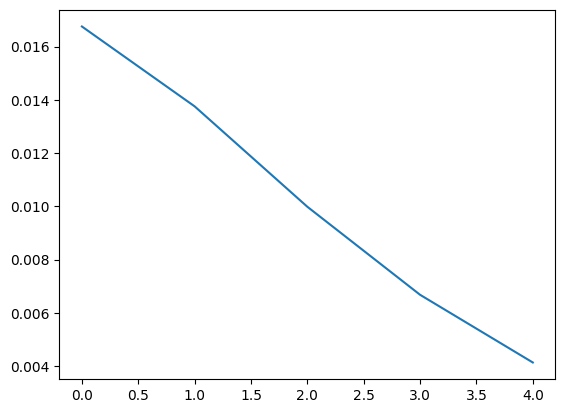

In [1334]:
def normalized_cross_correlation(patch1, patch2, epsilon=1e-6) -> jax.Array:
    """Similarity metric between two patches with dimensions C,H,W"""
    C, H, W = patch1.shape
    assert H >= 3 and W >= 3
    assert patch1.shape == patch2.shape
    # implement normalized cross correlation
    mean1 = jnp.mean(patch1, axis=(1, 2))[:, None, None]
    mean2 = jnp.mean(patch2, axis=(1, 2))[:, None, None]
    patch1_centered = patch1 - mean1
    patch2_centered = patch2 - mean2
    numerator = jnp.sum(patch1_centered * patch2_centered, axis=(1, 2))
    denominator1 = jnp.sqrt(jnp.sum(patch1_centered ** 2, axis=(1, 2)))
    denominator2 = jnp.sqrt(jnp.sum(patch2_centered ** 2, axis=(1, 2)))
    denominator = (denominator1 * denominator2) + epsilon
    ncc_value = numerator / denominator
    inverted_ncc = 1 - ncc_value
    normalized_ncc = inverted_ncc / 2.0
    return jnp.clip(normalized_ncc, 0, 1)

def patch_difference(patch1: jax.Array, patch2: jax.Array, epsilon=1e-6) -> jax.Array:
    C, H, W = patch1.shape
    pixel_sad = jnp.sum((patch1 - patch2)**2) / (C * H * W)
    return pixel_sad


sample_patch = jax.random.normal(jax.random.key(1), (2, 3, 3))
sample_patch2 = sample_patch.at[1, 0, 1].set(2.0)
print(patch_difference(sample_patch, sample_patch2))
level_indexes = range(len(f1_pyramid))
ncc_per_level = [patch_difference(f1_pyramid[i][0], f2_pyramid[i][0]) for i in level_indexes]
plt.plot(level_indexes, ncc_per_level)


In [1335]:
# @jax.jit
def shifted_center_patch(patch: jax.Array, flow: jax.Array) -> jax.Array:
    """given an C*H*W patch, returns an hypothetical center patch
    of dimensions C, H-1, W-1 that is off-centered by the given flow.
    when flow is 0.0, then the patch will be an interpolation center
    crop of a patch of size H,W to an H-1,W-1
    """
    C, H, W = patch.shape
    OH = H - 1
    OW = W - 1
    # flow is (dy, dx)
    # kernel should be ([(1-dx)*(1-dy), (dx*(1-dy)], [(1-dx)*dy, dx*dy]])
    neg_flow = 0.5 - flow
    pos_flow = 0.5 + flow
    kernel_y = jnp.array([[[neg_flow[0], pos_flow[0]]]])
    kernel_x = jnp.array([[[neg_flow[1], pos_flow[1]]]])

    patch_for_conv_x = patch.reshape(C * H, 1, W)
    conv_x = jax.lax.conv_general_dilated(
        patch_for_conv_x,
        kernel_x,
        window_strides=(1,),
        padding=((0, 0),),
        dimension_numbers=('NCW', 'IOW', 'NCW'),
    ).reshape(C, H, OW)
    patch_for_conv_y = conv_x.transpose(0, 2, 1).reshape(C * OW, 1, H)
    conv_y = jax.lax.conv_general_dilated(
        patch_for_conv_y,
        kernel_y,
        window_strides=(1,),
        padding=((0, 0),),
        dimension_numbers=('NCH', 'IOH', 'NCH'),
    ).reshape(C, OW, OH).transpose(0, 2, 1)

    return conv_y


# expected to be used in square patches, but works with rectangular ones.
sample_patch = jnp.arange(48).reshape(2, 4, 6).astype(jnp.float32)
sample_flow = jnp.array([0.5, -0.5])
print(sample_patch)
shifted_center_patch(sample_patch, sample_flow)

[[[ 0.  1.  2.  3.  4.  5.]
  [ 6.  7.  8.  9. 10. 11.]
  [12. 13. 14. 15. 16. 17.]
  [18. 19. 20. 21. 22. 23.]]

 [[24. 25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34. 35.]
  [36. 37. 38. 39. 40. 41.]
  [42. 43. 44. 45. 46. 47.]]]


Array([[[ 6.,  7.,  8.,  9., 10.],
        [12., 13., 14., 15., 16.],
        [18., 19., 20., 21., 22.]],

       [[30., 31., 32., 33., 34.],
        [36., 37., 38., 39., 40.],
        [42., 43., 44., 45., 46.]]], dtype=float32)

In [1336]:

def patch_flow_loss(patch1: jax.Array, patch2: jax.Array, flow: jax.Array) -> jax.Array:
    assert flow.shape == (2,)
    assert patch1.shape == patch2.shape
    # patch1, patch2 shape: 3,3
    # flow shape: 2,
    patch1_center = shifted_center_patch(patch1, -flow / 2)
    patch2_shifted = shifted_center_patch(patch2, flow / 2)
    return jnp.mean(patch_difference(patch1_center, patch2_shifted))


canvas = jax.random.normal(jax.random.key(1), (2, 5, 5))
patch0 = canvas[:, :-1, :-1]
patch1 = canvas[:, 1:, 1:]
l_shifted = patch_flow_loss(patch0, patch1, jnp.array([0.0, 0.0]))
l_match = patch_flow_loss(patch0, patch1, jnp.array([-1, -1.]))
print(l_shifted, l_match)

0.25699842 0.0


In [1337]:
def patch_flow_loss_grid(patches1: jax.Array, patches2: jax.Array, flow: (jax.Array)) -> (
        jax.Array):
    # patches1, patches2: [B, C, PY, PX, PH, PW]
    # flow: [B, 2, PY, PX]
    # return [B, PY, PX]
    assert patches1.shape == patches2.shape
    B, C, PY, PX, PH, PW = patches1.shape
    FB, FC, FY, FX = flow.shape
    assert FB == B
    assert FC == 2
    assert FY == PY
    assert FX == PX
    flat_patches1 = (
        patches1.transpose(0, 2, 3, 1, 4, 5).reshape(B * PY * PX, C, PH, PW)
    )
    flat_patches2 = (
        patches2.transpose(0, 2, 3, 1, 4, 5).reshape(B * PY * PX, C, PH, PW)
    )
    # flat_patches1 = patches1.reshape(B * C * PY * PX, PH, PW)
    # flat_patches2 = patches2.reshape(B * C * PY * PX, PH, PW)
    flat_flow = flow.transpose(0, 2, 3, 1).reshape(B * PY * PX, FC)
    flat_losses = jax.vmap(patch_flow_loss)(flat_patches1, flat_patches2, flat_flow)
    return flat_losses.reshape(B, PY, PX)


sample_patch_grid = jax.random.normal(
    jax.random.key(1), (2, 2, 3, 4, 5, 6)
)
sample_flow = jnp.zeros((2, 2, 3, 4)).astype(jnp.float32)
altered_patch_grid = sample_patch_grid.at[0, 1, 2, 3, 0, 0].set(10.0)
loss_grid = patch_flow_loss_grid(sample_patch_grid, altered_patch_grid, sample_flow)
print(jnp.mean(loss_grid), jnp.max(loss_grid), loss_grid[0, 2, 3])


0.0067493515 0.16198443 0.16198443


In [1338]:
def aggregate_patch_flow_loss_grid(patch_grid1: jax.Array, patch_grid2: jax.Array,
                                   flow_grid: jax.Array) -> jax.Array:
    loss = patch_flow_loss_grid(patch_grid1, patch_grid2, flow_grid)
    return jnp.sum(loss)


patch_grid_flow_loss_with_grad = jax.jit(
    jax.value_and_grad(aggregate_patch_flow_loss_grid, argnums=2))
patch_grid_flow_loss_with_grad(sample_patch_grid, altered_patch_grid, sample_flow)

(Array(0.16198, dtype=float32),
 Array([[[[ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     , -0.40843]],
 
         [[ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     , -0.1424 ]]],
 
 
        [[[ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ]],
 
         [[ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ],
          [ 0.     ,  0.     ,  0.     ,  0.     ]]]], dtype=float32))

In [1339]:
# @jax.jit
def estimate_flow_grid(patches1: jax.Array, patches2: jax.Array, priors: jax.Array) -> jax.Array:
    B, C, PY, PX, PH, PW = patches1.shape
    for i in range(10):
        loss0, grad0 = patch_grid_flow_loss_with_grad(
            patches1,
            patches2,
            priors,
        )
        priors -= jnp.clip(grad0 / (10 * loss0 + 1e-6), -1, 0.1)
    return priors


estimate_flow_grid(sample_patch_grid, altered_patch_grid, sample_flow)


Array([[[[0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.15343]],

        [[0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.07843]]],


       [[[0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ]],

        [[0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ],
         [0.     , 0.     , 0.     , 0.     ]]]], dtype=float32)

In [1340]:
base = jax.random.normal(jax.random.PRNGKey(555), shape=(1, 1, 3, 3, 5, 5)) * 0.2 + 0.5
patches1 = base[:, :, :, :, :4, :4]
patches2 = base[:, :, :, :, :4, 1:5]
prior = jax.random.normal(jax.random.key(1), (1, 2, 3, 3)) * 0.01
initial_loss = patch_flow_loss_grid(patches1, patches2, prior)
estimated_flow = estimate_flow_grid(patches1, patches2, prior)
final_loss = patch_flow_loss_grid(patches1, patches2, estimated_flow)
print("Initial loss\n", initial_loss)
print("Estimated flow\n", estimated_flow)
print("Final loss\n", final_loss)
print("Loss reduction\n", (initial_loss - final_loss) / (initial_loss + 1e-8))
# patch_flow_loss_grid()
# print(patch_flow_loss(patch1, patch2, prior))
# estimate_flow_single_patch(patch1, patch2, prior)


Initial loss
 [[[0.0176  0.01087 0.00876]
  [0.02287 0.00974 0.00749]
  [0.00571 0.02786 0.00289]]]
Estimated flow
 [[[[-0.0419  -0.01354  0.00069]
   [ 0.07067 -0.00949 -0.09746]
   [-0.02142  0.02731  0.05237]]

  [[-0.36185 -0.25108 -0.20363]
   [-0.43881 -0.21108 -0.16155]
   [-0.1275  -0.508   -0.08657]]]]
Final loss
 [[[0.00699 0.00617 0.00558]
  [0.00665 0.00594 0.00444]
  [0.00417 0.00654 0.00228]]]
Loss reduction
 [[[0.60302 0.43214 0.36265]
  [0.70911 0.3902  0.40743]
  [0.2689  0.76526 0.21182]]]


In [1341]:
def conv_output_size(input_size: int, kernel_size: int, stride: int):
    return (input_size - kernel_size) // stride + 1


def extract_patches_nchw(img: jax.Array, patch_size: int, stride: int) -> jax.Array:
    #img: (B, C, H, W)
    #returns: (B,C,PATCHES_Y,PATCHES_X, PH, PW)
    B, C, H, W = img.shape
    depth_patches = jax.lax.conv_general_dilated_patches(
        img, (patch_size, patch_size), (stride, stride), padding='VALID'
    ).transpose(0, 2, 3, 1)
    PH = conv_output_size(H, patch_size, stride)
    PW = conv_output_size(W, patch_size, stride)
    patches = depth_patches.reshape(B, PH, PW, C, patch_size, patch_size)
    return patches.transpose(0, 3, 1, 2, 4, 5)


sample_img = jnp.arange(2 * 2 * 8 * 8).reshape(2, 2, 8, 8).astype(jnp.float32)
patches = extract_patches_nchw(sample_img, patch_size=4, stride=2)
patches.shape

(2, 2, 3, 3, 4, 4)

In [1342]:
def estimate_lowest_pyramid_level(patch_size: int, stride: int):
    patches1 = extract_patches_nchw(f1_pyramid[-1], patch_size, stride)
    patches2 = extract_patches_nchw(f2_pyramid[-1], patch_size, stride)
    B, C, PY, PX, PH, PW = patches1.shape
    prior = jnp.zeros((B, 2, PY, PX)).astype(jnp.float32)
    initial_loss = patch_flow_loss_grid(patches1, patches2, prior)
    flow = estimate_flow_grid(patches1, patches2, prior)
    final_loss = patch_flow_loss_grid(patches1, patches2, flow)
    return flow, initial_loss, final_loss


flow, initial, final = estimate_lowest_pyramid_level(patch_size=4, stride=2)
print("Flow\n", flow)
print("Initial loss\n", initial)
print("Final loss\n", final)
print("Loss reduction\n", (initial - final) / (initial + 1e-10))

Flow
 [[[[ 0.00656  0.39903  0.50701]
   [ 0.01077  0.60301  0.73059]
   [ 0.00195  0.08284  0.19632]]

  [[-0.01184 -0.15115 -0.05221]
   [-0.0116  -0.34718 -0.27531]
   [ 0.00473 -0.05338 -0.12489]]]]
Initial loss
 [[[0.0002  0.00485 0.00668]
  [0.00027 0.01109 0.01311]
  [0.00008 0.00097 0.0017 ]]]
Final loss
 [[[0.0002  0.00147 0.00149]
  [0.00027 0.00091 0.00121]
  [0.00008 0.00079 0.00056]]]
Loss reduction
 [[[0.01653 0.69729 0.77644]
  [0.01674 0.91767 0.90777]
  [0.00567 0.18029 0.67082]]]


In [1343]:
def upscale_flow_2n_plus_2(flow: jax.Array, rescale_values: bool = True) -> jax.Array:
    B, F, H, W = flow.shape
    assert F == 2
    if rescale_values:
        upscale_ratio = (2 * H + 2) / H
        flow = upscale_ratio * flow  # incorrect
    extended_upscaled_flow = flow.repeat(2, axis=2).repeat(2, axis=3)
    extended_padded_upscaled_flow = jnp.pad(
        extended_upscaled_flow, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='edge'
    )
    kernel = jnp.array([[[0.3, 1, 0.3]]]).astype(jnp.float32)
    kernel = kernel / jnp.sum(kernel)
    smooth_upscaled_flow = reduce_images_separable_convolution(
        extended_padded_upscaled_flow, kernel, stride=1
    )
    return smooth_upscaled_flow


flow, _, _ = estimate_lowest_pyramid_level(4, 2)
print(flow.shape)
upscaled = upscale_flow_2n_plus_2(flow)
print(upscaled.shape)
print("Original Flow\n", flow)
print("Upscaled and smooth Flow\n", upscaled)


(1, 2, 3, 3)
(1, 2, 8, 8)
Original Flow
 [[[[ 0.00656  0.39903  0.50701]
   [ 0.01077  0.60301  0.73059]
   [ 0.00195  0.08284  0.19632]]

  [[-0.01184 -0.15115 -0.05221]
   [-0.0116  -0.34718 -0.27531]
   [ 0.00473 -0.05338 -0.12489]]]]
Upscaled and smooth Flow
 [[[[ 0.0175   0.0175   0.21373  0.86784  1.11807  1.29803  1.35202  1.35202]
   [ 0.0175   0.0175   0.21373  0.86784  1.11807  1.29803  1.35202  1.35202]
   [ 0.0196   0.0196   0.23456  0.9511   1.22189  1.40799  1.46381  1.46381]
   [ 0.02661  0.02661  0.304    1.22865  1.56799  1.77449  1.83644  1.83644]
   [ 0.0243   0.0243   0.27249  1.09977  1.41041  1.61863  1.6811   1.6811 ]
   [ 0.00961  0.00961  0.098    0.39261  0.53906  0.73259  0.79064  0.79064]
   [ 0.00521  0.00521  0.04565  0.18047  0.27765  0.46677  0.52351  0.52351]
   [ 0.00521  0.00521  0.04565  0.18047  0.27765  0.46677  0.52351  0.52351]]

  [[-0.03157 -0.03157 -0.10122 -0.33341 -0.35359 -0.18869 -0.13922 -0.13922]
   [-0.03157 -0.03157 -0.10122 -0.33341 -

In [1344]:
def get_valid_offsets_grid(H, W, offsets_grid_flat, patch_size):
    valid_y_min = offsets_grid_flat[0, :] >= 0
    valid_x_min = offsets_grid_flat[1, :] >= 0
    valid_y_max = (offsets_grid_flat[0, :] + patch_size) <= H
    valid_x_max = (offsets_grid_flat[1, :] + patch_size) <= W
    valid_coords_flat = jnp.logical_and(
        jnp.logical_and(valid_y_min, valid_x_min),
        jnp.logical_and(valid_y_max, valid_x_max)
    )
    return valid_coords_flat


get_valid_offsets_grid(2, 2, jnp.array([[0, 2, 1], [0, 0, 1]]), 2)

Array([ True, False, False], dtype=bool)

In [1345]:
def extract_single_shifted_patch(img: jax.Array, offset: jax.Array, patch_size: int):
    """
    img: C, H, W
    start_yx: 2,
    patch_size: ()
    returns: C, patch_size, patch_size
    """
    C, H, W = img.shape
    assert offset.shape == (2,)
    return jax.lax.dynamic_slice(
        img,
        (0, offset[0], offset[1]),
        (C, patch_size, patch_size),
        allow_negative_indices=False
    )


def extract_shifted_patches_nchw(single_frame, frame_int_flow, patch_size: int, stride: int):
    """
    single_frame: C, H, W
    frame_int_flow: 2, H-patch_size+1, W-patch_size+1
    assumes stride=1
    returns (
        C * (H-patch_size+1) * (W-patch_size+1), patch_size, patch_size,
        C * (H-patch_size+1) * (W-patch_size+1), 1 (bool)
    """
    C, H, W = single_frame.shape
    F, FH, FW = frame_int_flow.shape
    assert F == 2
    # print(FH, conv_output_size(H, patch_size, stride))
    assert FH == conv_output_size(H, patch_size, stride)
    assert FW == conv_output_size(W, patch_size, stride)
    grid_pair = jnp.meshgrid(
        jnp.arange(FH), jnp.arange(FW), indexing='ij'
    )
    grid = jnp.stack(grid_pair, axis=0) * stride
    offsets_grid = grid + frame_int_flow
    offsets_grid_flat = offsets_grid.reshape(2, -1)
    valid_coords_flat = get_valid_offsets_grid(H, W, offsets_grid_flat, patch_size)
    extract_all_patches = jax.vmap(extract_single_shifted_patch, in_axes=(None, 1, None))
    patches = extract_all_patches(single_frame, offsets_grid_flat, patch_size)
    return patches.reshape(C, FH, FW, patch_size, patch_size), valid_coords_flat.reshape(FH, FW)


batch_extract_shifted_patches_nchw = jax.vmap(extract_shifted_patches_nchw,
                                              in_axes=(0, 0, None, None))

# test by picking the opposite corner patches
base = grid = jnp.arange(36).reshape(6, 6)
# flow = jnp.array([[[1, 1], [-1, -1]], [[1, -1], [1, -1]]])
flow = jnp.zeros((2, 2, 2)).astype(jnp.int32)
# flow = jnp.array([[[1, 1], [1, -1]], [[-1, 1], [-1, -1]]])
shifted_patches, valid = extract_shifted_patches_nchw(grid[None, ...], flow, 4, 2)
# print(base)
# print(patches)
# print(valid)
just_patches = extract_patches_nchw(grid[None, None, ...], 4, 2)

shifted_patches



Array([[[[[ 0,  1,  2,  3],
          [ 6,  7,  8,  9],
          [12, 13, 14, 15],
          [18, 19, 20, 21]],

         [[ 2,  3,  4,  5],
          [ 8,  9, 10, 11],
          [14, 15, 16, 17],
          [20, 21, 22, 23]]],


        [[[12, 13, 14, 15],
          [18, 19, 20, 21],
          [24, 25, 26, 27],
          [30, 31, 32, 33]],

         [[14, 15, 16, 17],
          [20, 21, 22, 23],
          [26, 27, 28, 29],
          [32, 33, 34, 35]]]]], dtype=int32)

/tmp/ipykernel_1794795/1733517819.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


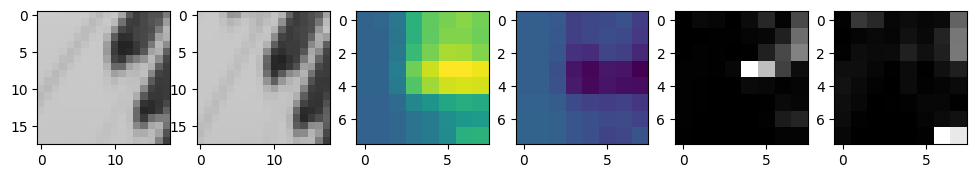

In [1346]:
# def estimate_flow_patches_grid(patches1, patches2, priors):
#     assert patches1.shape == patches2.shape
#     B, C, PY, PX, PH, PW = patches1.shape
#     assert priors.shape == (B, 2, PY, PX)
#     flat_patches1 = patches1.reshape(B * C * PY * PX, PH, PW)
#     flat_patches2 = patches2.reshape(B * C * PY * PX, PH, PW)
#     flat_priors = priors.transpose(0, 2, 3, 1).reshape(B * PY * PX, 2)
#     flat_flow = estimate_flow_patches(flat_patches1, flat_patches2, flat_priors)
#     return flat_flow.reshape(B, PY, PX, 2).transpose(0, 3, 1, 2)


def estimate_flow_single_level(img1: jax.Array, img2: jax.Array,
                               prior: jax.Array, patch_size: int,
                               stride: int) -> tuple[jax.Array, jax.Array, jax.Array]:
    # returns a B, 4, PX, PY. flow channels are (flow_y, flow_x, initial_loss, final_loss)
    # shape of img1, img2: (B, C, H, W)
    # shape of prior: (B, 2, H, W)
    patches1 = extract_patches_nchw(img1, patch_size, stride)
    B, C, W, H, PH, PW = patches1.shape
    int_priors = jnp.round(prior).astype(jnp.int32)
    remainder_priors = prior - int_priors
    patches2, patch_validity = batch_extract_shifted_patches_nchw(
        img2, int_priors, patch_size, stride
    )
    initial_loss = patch_flow_loss_grid(patches1, patches2, prior)[:,None,:,:]
    residual_flow = estimate_flow_grid(patches1, patches2, remainder_priors)
    flow = residual_flow + int_priors
    final_loss = patch_flow_loss_grid(patches1, patches2, residual_flow)[:,None,:,:]
    # level_loss = patch_flow_loss_grid(patches1, patches2, level_flow)
    stacked = jnp.concatenate([flow, initial_loss, final_loss], axis=1)
    return stacked
    # return jax.lax.select(
    #     patch_validity.repeat(2, axis=0)[None, :, :, :],
    #     level_flow + int_priors,
    #     jnp.zeros((B, 2, W, H))
    # )
    # corrected_level_flow = flow_loss_correction(level_flow, level_loss)
    # return corrected_level_flow + int_priors


prior0 = jnp.zeros((1, 2, 3, 3)).astype(jnp.float32)
flow0 = estimate_flow_single_level(
    f1_pyramid[-1], f2_pyramid[-1], prior0, patch_size=4, stride=2)
upscaled_flow = upscale_flow_2n_plus_2(flow0[:,0:2,:,:])
flow1 = estimate_flow_single_level(
    f1_pyramid[-2], f2_pyramid[-2], upscaled_flow, patch_size=4, stride=2
)
fig, axes = plt.subplots(1, 6, figsize=(12, 12))
m_flow = jnp.min(flow1[:,0:2,:,:])
M_flow = jnp.max(flow1[:,0:2,:,:])
axes[0].imshow(f1_pyramid[-2][0, 0], cmap='gray', vmin=0, vmax=1)
axes[1].imshow(f2_pyramid[-2][0, 0], cmap='gray', vmin=0, vmax=1)
axes[2].imshow(flow1[0, 0], cmap='viridis', vmin=m_flow, vmax=M_flow)
axes[3].imshow(flow1[0, 1], cmap='viridis', vmin=m_flow, vmax=M_flow)
axes[4].imshow(flow1[0, 2], cmap='gray')
axes[5].imshow(flow1[0, 3], cmap='gray')
fig.show()

In [1347]:

from functools import partial


@partial(jax.jit, static_argnums=(3, 4))
def estimate_flow_multiple_levels(pyramid1: jax.Array, pyramid2: jax.Array,
                                  prior: jax.Array, patch_size: int, stride: int) -> jax.Array:
    B, C, H, W = pyramid1[-1].shape
    expected_prior_shape = (
        B,
        2,
        conv_output_size(H, patch_size, stride),
        conv_output_size(W, patch_size, stride),
    )
    assert prior.shape == expected_prior_shape
    flows = []
    for img1, img2 in zip(reversed(pyramid1), reversed(pyramid2)):
        flow = estimate_flow_single_level(img1, img2, prior, patch_size, stride)
        flows.append(flow)
        prior = upscale_flow_2n_plus_2(flow[:,0:2])
    return flows[::-1]


In [1348]:
def apply_flow_entire_image(img: jax.Array, flow: jax.Array) -> jax.Array:
    flow_y, flow_x = flow[0]
    H, W = flow_y.shape
    grid_y, grid_x = jnp.meshgrid(jnp.arange(H), jnp.arange(W), indexing='ij')
    return jax.scipy.ndimage.map_coordinates(img[0, 0], [grid_y + flow_y, grid_x + flow_x], order=1)

In [1349]:
prior = jnp.zeros((1, 2, 3, 3))
flows = estimate_flow_multiple_levels(f1_pyramid, f2_pyramid, prior, patch_size=4, stride=2)
print([f.shape for f in f1_pyramid])
print([f.shape for f in f2_pyramid])
print([f.shape for f in flows])

[(1, 1, 158, 158), (1, 1, 78, 78), (1, 1, 38, 38), (1, 1, 18, 18), (1, 1, 8, 8)]
[(1, 1, 158, 158), (1, 1, 78, 78), (1, 1, 38, 38), (1, 1, 18, 18), (1, 1, 8, 8)]
[(1, 4, 78, 78), (1, 4, 38, 38), (1, 4, 18, 18), (1, 4, 8, 8), (1, 4, 3, 3)]


In [1350]:
print(flows[-1])

[[[[ 0.00656  0.39903  0.50701]
   [ 0.01077  0.60301  0.73059]
   [ 0.00195  0.08284  0.19632]]

  [[-0.01184 -0.15115 -0.05221]
   [-0.0116  -0.34718 -0.27531]
   [ 0.00473 -0.05338 -0.12489]]

  [[ 0.0002   0.00485  0.00668]
   [ 0.00027  0.01109  0.01311]
   [ 0.00008  0.00097  0.0017 ]]

  [[ 0.0002   0.00147  0.00149]
   [ 0.00027  0.00091  0.00121]
   [ 0.00008  0.00079  0.00056]]]]


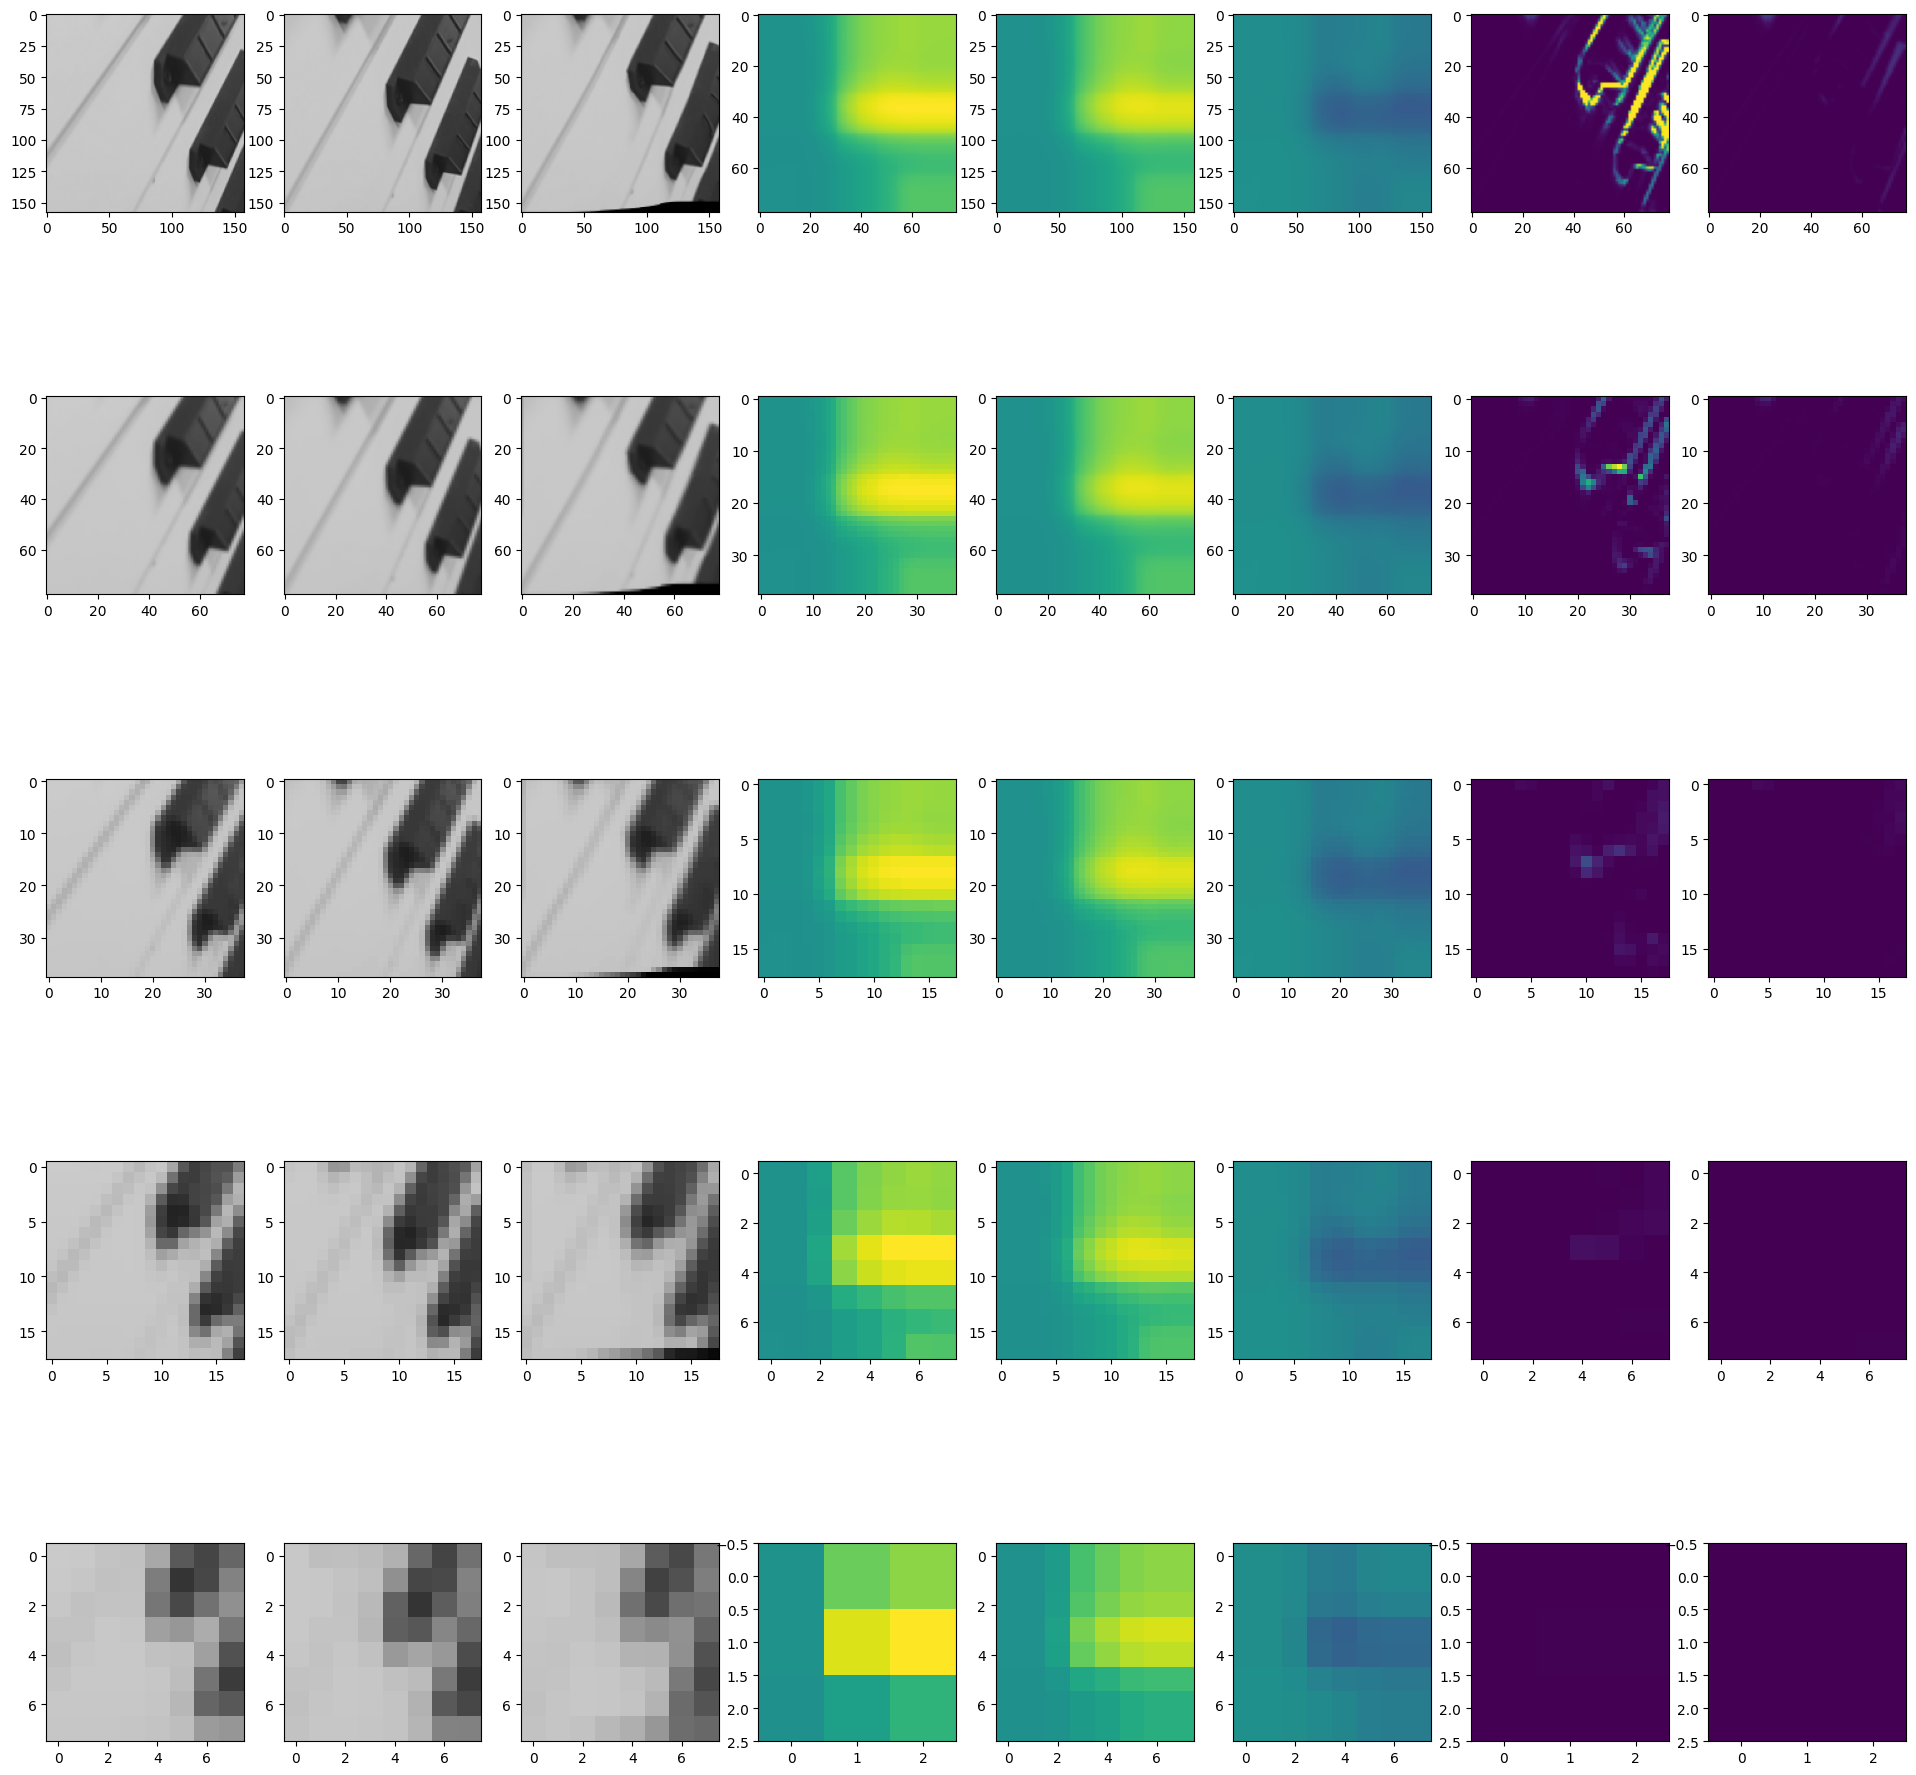

In [1351]:
fig, axs = plt.subplots(len(flows), 8, figsize=(24, 24))

M_loss = max(
    [jnp.max(flow_with_loss[:,2:]) for flow_with_loss in flows[1:]]
)
m_loss = min(
    [jnp.min(flow_with_loss[:,2:]) for flow_with_loss in flows[1:]]
)

for img1, img2, flow_with_loss, ax in zip(f1_pyramid, f2_pyramid, flows, axs):
    flow_norm = jnp.linalg.norm(flow_with_loss[:,:2], ord=2, axis=1)
    M = jnp.max(flow_norm)
    m = -M
    ax[0].imshow(img1[0, 0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(img2[0, 0], cmap='gray', vmin=0, vmax=1)
    upscaled_flow = upscale_flow_2n_plus_2(flow_with_loss[:,:2], rescale_values=False)
    flowed_img2 = apply_flow_entire_image(img2, upscaled_flow)
    ax[2].imshow(flowed_img2, cmap='gray', vmin=0, vmax=1)
    ax[3].imshow(flow_norm[0, :, :], cmap='viridis', vmin=m, vmax=M)
    ax[4].imshow(upscaled_flow[0, 0, :, :], cmap='viridis', vmin=m, vmax=M)
    ax[5].imshow(upscaled_flow[0, 1, :, :], cmap='viridis', vmin=m, vmax=M)
    ax[6].imshow(flow_with_loss[0, 2, :, :], cmap='viridis', vmax=M_loss, vmin=m_loss)
    ax[7].imshow(flow_with_loss[0, 3, :, :], cmap='viridis', vmax=M_loss, vmin=m_loss)
    # fig.colorbar(right, ax=ax)
#


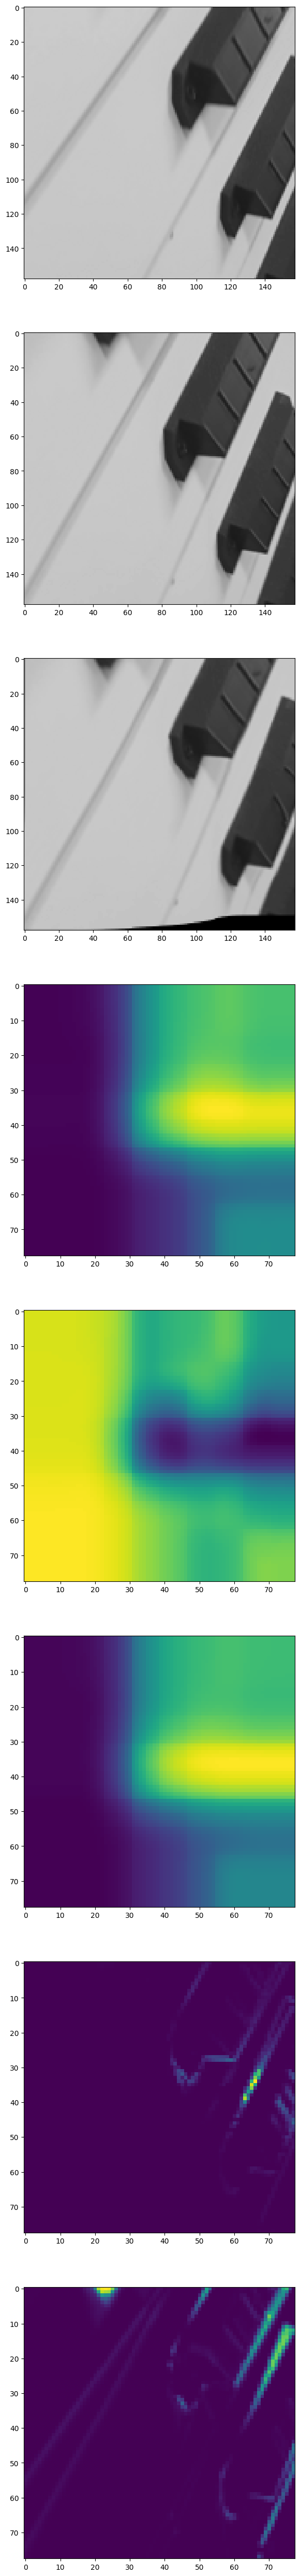

In [1352]:


flow_with_loss_fine_grained = flows[0]
f2_fine_grained = f2_pyramid[0]
upscaled_flow = upscale_flow_2n_plus_2(flow_with_loss_fine_grained[:,0:2], rescale_values=False)
flowed_large = apply_flow_entire_image(f2_fine_grained, upscaled_flow)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(12, 64))
ax1.imshow(f1_pyramid[0][0, 0], cmap='gray', vmin=0, vmax=1)
ax2.imshow(f2_pyramid[0][1, 0], cmap='gray', vmin=0, vmax=1)
ax3.imshow(flowed_large, cmap='gray', vmin=0, vmax=1)
ax4.imshow(flow_with_loss_fine_grained[0, 0], cmap='viridis', )
ax5.imshow(flow_with_loss_fine_grained[0, 1], cmap='viridis', )
ax6.imshow(jnp.linalg.norm(flow_with_loss_fine_grained[0,0:2], axis=0), cmap='viridis')
ax7.imshow(flow_with_loss_fine_grained[0, 2], cmap='viridis')
ax8.imshow(flow_with_loss_fine_grained[0, 3], cmap='viridis')

plt.show()

In [1353]:
a = jnp.arange(16).reshape(1, 1, 4, 4).astype(jnp.float32)
b = jnp.ones((1, 1, 2, 2)).astype(jnp.float32)
b = b / jnp.sum(b)
# print(a)
c = a.repeat(2, axis=2).repeat(2, axis=3)
interpolated = jax.lax.conv_general_dilated(c, b, (1, 1), ((0, 0), (0, 0)))
padded = jnp.pad(interpolated, ((0, 0), (0, 0), (1, 1), (1, 1)), mode='edge')
padded

Array([[[[ 0. ,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3. ],
         [ 0. ,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3. ],
         [ 2. ,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5. ],
         [ 4. ,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7. ],
         [ 6. ,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9. ],
         [ 8. ,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11. ],
         [10. , 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13. ],
         [12. , 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15. ],
         [12. , 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15. ]]]], dtype=float32)

In [1354]:
def f(flow: jax.Array) -> jax.Array:
    return jnp.sum(flow)


f_grad = jax.value_and_grad(f)
value, grad = f_grad(jnp.array([3., 5.]))
grad

Array([1., 1.], dtype=float32)

In [1359]:
size = 3
print(size)
for i in range(10):
    size = 2*size+2
    print(size)


3
8
18
38
78
158
318
638
1278
2558
5118


In [1360]:
def get_offsets(input_size: int, output_size: int):
    reminder = input_size - output_size
    start = reminder // 2
    end = input_size - (reminder - start)
    return start, end

get_offsets(200, 200)

(0, 200)